 # ECBMBM 4060 Project – Examination of Drug Likeness for Covid-19 Database

_**Team Members:
Zelin Yu (zy2489) Zixuan Liu (zl3105)**_

The project was dealt by us in four parts, namely:<br>
1. **Data Retrieval**: Collection of bioactivity database for SARS Coronavirus (Single Protein) from ChEMBL using chembl_webresource_client. <br>
2. **Data Pre-processing**: Classifying the bioactivity of the compounds by IC50 value (as active, inactive or intermediate) and making a dataframe with only the relevant columns from unprocessed database (and further, saving it into a separate .csv file). <br>
3. **Making and adding descriptors**: Making and adding relevant descriptors (ALogP, PSA, Mol. Wt., Number of H acceptors and H donors) and combining pre-processed data and these molecular descriptors. <br>
4. **Applying different ML models on the data**: Using the above data, splitting it into testing and training data sets, applying different ML models and checking their accuracy.<br>

### Part 1: Data Retrieval

In [1]:
!pip install chembl_webresource_client

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 596 kB 35.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires itsdangerous<2.0,>=0.24, but you have itsdangerous 2.0.1 which is incompatible.


In [2]:
# Importing the ChEMBl webresource for searching targets and downloading data.

import pandas as pd
from chembl_webresource_client.new_client import new_client

In [3]:
# Searching by the string 'coronavirus' and saving all the target results in targets Dataframe.

target_query = new_client.target.search('coronavirus') 

# A total of 7 results (5 cellline databases and 2 bioactivity databases of single-protein type organisms).

targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


_**Note**: We decided to work with the **Replicase polyprotein 1ab** single-protein database, out of the two options._

In [4]:
# Selecting the target.

selected_target = targets.target_chembl_id[6] 

In [5]:
# Filtering out only the IC50 type molecules from the selected target (SARS Coronavirus Replicase polyprotein 1ab).

activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1988091,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...,Outside typical range,Values for this activity type are unusually la...,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,None,CHEMBL194398,None,CHEMBL194398,None,False,http://www.openphacts.org/units/Nanomolar,663132,=,1,True,=,None,IC50,nM,None,870000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,870.0
1,None,1988092,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,Outside typical range,Values for this activity type are unusually la...,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,None,CHEMBL393608,None,CHEMBL393608,None,False,http://www.openphacts.org/units/Nanomolar,663138,=,1,True,=,None,IC50,nM,None,200000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,200.0
2,None,1988093,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,Outside typical range,Values for this activity type are unusually la...,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,None,CHEMBL238216,None,CHEMBL238216,None,False,http://www.openphacts.org/units/Nanomolar,663137,=,1,True,=,None,IC50,nM,None,300000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,300.0
3,None,1988094,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,None,None,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,"{'bei': '7.31', 'le': '0.14', 'lle': '3.95', '...",CHEMBL235873,None,CHEMBL235873,4.82,False,http://www.openphacts.org/units/Nanomolar,663136,=,1,True,=,None,IC50,nM,None,15000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,15.0
4,None,1988095,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,None,None,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,"{'bei': '7.99', 'le': '0.16', 'lle': '4.33', '...",CHEMBL397154,None,CHEMBL397154,5.00,False,http://www.openphacts.org/units/Nanomolar,663135,=,1,True,=,None,IC50,nM,None,10000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,None,18548176,[],CHEMBL4198706,Inhibition of SARS coronavirus 3CL protease us...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(C)C[C@H](NC(=O)OC1(Cc2ccccc2)CCN(S(C)(=O)=O...,None,None,CHEMBL4196085,Eur J Med Chem,2018,"{'bei': '8.30', 'le': '0.17', 'lle': '4.99', '...",CHEMBL4208764,None,CHEMBL4301230,5.37,False,http://www.openphacts.org/units/Nanomolar,3079451,=,1,True,=,None,IC50,nM,None,4300.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,4.

In [6]:
# Removing all the chemical compound entries where the IC50 value is missing.

df2 = df[df.standard_value.notna()]
df2

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,ligand_efficiency,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,1988091,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...,Outside typical range,Values for this activity type are unusually la...,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,None,CHEMBL194398,None,CHEMBL194398,None,False,http://www.openphacts.org/units/Nanomolar,663132,=,1,True,=,None,IC50,nM,None,870000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,870.0
1,None,1988092,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,Outside typical range,Values for this activity type are unusually la...,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,None,CHEMBL393608,None,CHEMBL393608,None,False,http://www.openphacts.org/units/Nanomolar,663138,=,1,True,=,None,IC50,nM,None,200000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,200.0
2,None,1988093,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,Outside typical range,Values for this activity type are unusually la...,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,None,CHEMBL238216,None,CHEMBL238216,None,False,http://www.openphacts.org/units/Nanomolar,663137,=,1,True,=,None,IC50,nM,None,300000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,300.0
3,None,1988094,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,None,None,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,"{'bei': '7.31', 'le': '0.14', 'lle': '3.95', '...",CHEMBL235873,None,CHEMBL235873,4.82,False,http://www.openphacts.org/units/Nanomolar,663136,=,1,True,=,None,IC50,nM,None,15000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,15.0
4,None,1988095,[],CHEMBL898907,Inhibition of SARS-CoV 3C-like protease by FRE...,B,None,None,BAO_0000190,BAO_0000019,assay format,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,None,None,CHEMBL1137503,Bioorg. Med. Chem. Lett.,2007,"{'bei': '7.99', 'le': '0.16', 'lle': '4.33', '...",CHEMBL397154,None,CHEMBL397154,5.00,False,http://www.openphacts.org/units/Nanomolar,663135,=,1,True,=,None,IC50,nM,None,10000.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,None,18548176,[],CHEMBL4198706,Inhibition of SARS coronavirus 3CL protease us...,B,None,None,BAO_0000190,BAO_0000357,single protein format,CC(C)C[C@H](NC(=O)OC1(Cc2ccccc2)CCN(S(C)(=O)=O...,None,None,CHEMBL4196085,Eur J Med Chem,2018,"{'bei': '8.30', 'le': '0.17', 'lle': '4.99', '...",CHEMBL4208764,None,CHEMBL4301230,5.37,False,http://www.openphacts.org/units/Nanomolar,3079451,=,1,True,=,None,IC50,nM,None,4300.0,CHEMBL5118,SARS coronavirus,Replicase polyprotein 1ab,227859,None,None,IC50,uM,UO_0000065,None,4.

In [7]:
# Re-indexing the data frame after removal of missing data rows.

df2.index=range(len(df2))

In [8]:
# Saving unprocessed,filtered raw data.

df2.to_csv('Results\Data_Replicase polyprotein 1ab_Unprocessed.csv', index=False)

### Part 2: Data Pre-processing

In [9]:
# Classification of Bioactivity of compounds (inactive;active;intermediate) by IC50 value.
# Note that the Bioactivity Data of each Compounds is in the IC50 unit.

bioactivity_class = []
for i in df2.standard_value:
  if float(i) >= 10000:
    bioactivity_class.append("inactive")
  elif float(i) <= 1000:
    bioactivity_class.append("active")
  elif (float(i)>1000) & (float(i)<10000):
    bioactivity_class.append("intermediate")

In [10]:
# Combining necessary data columns needed for descriptors and model making.

bioactivity_class = pd.Series(bioactivity_class, name='bioactivity_class')
df2 = pd.concat([df2, bioactivity_class], axis=1)
selection = ['molecule_chembl_id','canonical_smiles','standard_value','bioactivity_class','value']
df3 = df2[selection]
df3

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,value
0,CHEMBL194398,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...,870000.0,inactive,870.0
1,CHEMBL393608,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,200000.0,inactive,200.0
2,CHEMBL238216,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,300000.0,inactive,300.0
3,CHEMBL235873,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,15000.0,inactive,15.0
4,CHEMBL397154,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,10000.0,inactive,10.0
...,...,...,...,...,...
209,CHEMBL4208764,CC(C)C[C@H](NC(=O)OC1(Cc2ccccc2)CCN(S(C)(=O)=O...,4300.0,intermediate,4.3
210,CHEMBL4212620,CCC1(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C=O)C[C@...,5500.0,intermediate,5.5
211,CHEMBL4216101,CCC1(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C[C@@H]...,4100.0,intermediate,4.1
212,CHEMBL4217568,CCOC(=O)N1CCC(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H]...,3200.0,intermediate,3.2


In [11]:
# Saving pre-processed data.

df3.to_csv('Results\Data_Replicase polyprotein 1ab_Processed.csv', index=False)

### Part 3: Making and adding Data Descriptors

In [12]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y

--2021-12-21 03:36:01--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   154MB/s    in 0.5s    

2021-12-21 03:36:01 (154 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b64

In [13]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [14]:
# Importing rdkit to make the descriptors from SMILES of each compound.

import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [15]:
# Defining a function to find relevant descriptors as given by the Lipinski's Rule of Five, 
# These descriptors are the global factors which will determine the drug_likeness of a compound.
# The function takes the SMILES notation of each compound as the input.
# More on this is written in the "Project_Description.pdf" file in the root directory.

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_TPSA = Descriptors.TPSA(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_TPSA,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","ALogP","PSA","NumHDonors","NumHAcceptors"] # The Descriptors for the compounds, that we are choosing.
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

# Note:Although TPSA is not exactly a Lipinski Descriptor, we considered TPSA(aka PSA) too as it was mentioned by Parthiban Sir.

In [16]:
# Making the dataframe of descriptors for the pre-processed data (descriptors are found for our data, using 
# the lipinski() function above).

df_lipinski = lipinski(df3.canonical_smiles)
df_lipinski

,MW,ALogP,PSA,NumHDonors,NumHAcceptors
0,580.682,2.68582,156.70,3.0,8.0
1,547.653,1.39862,168.73,4.0,8.0
2,581.670,1.59522,168.73,4.0,8.0
3,659.781,0.87060,201.26,6.0,9.0
4,625.764,0.67400,201.26,6.0,9.0
...,...,...,...,...,...
209,668.767,-2.95720,211.34,4.0,10.0
210,524.659,2.51690,143.14,3.0,7.0
211,628.721,-1.81440,203.50,4.0,10.0
212,468.551,0.95810,143.14,3.0,7.0


In [17]:
# Combining the pre-processed data and the descriptors dataframe we made in the above step, into a single dataframe.

df_combined = pd.concat([df3,df_lipinski],axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,value,MW,ALogP,PSA,NumHDonors,NumHAcceptors
0,CHEMBL194398,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...,870000.0,inactive,870.0,580.682,2.68582,156.70,3.0,8.0
1,CHEMBL393608,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,200000.0,inactive,200.0,547.653,1.39862,168.73,4.0,8.0
2,CHEMBL238216,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,300000.0,inactive,300.0,581.670,1.59522,168.73,4.0,8.0
3,CHEMBL235873,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,15000.0,inactive,15.0,659.781,0.87060,201.26,6.0,9.0
4,CHEMBL397154,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,10000.0,inactive,10.0,625.764,0.67400,201.26,6.0,9.0
...,...,...,...,...,...,...,...,...,...,...
209,CHEMBL4208764,CC(C)C[C@H](NC(=O)OC1(Cc2ccccc2)CCN(S(C)(=O)=O...,4300.0,intermediate,4.3,668.767,-2.95720,211.34,4.0,10.0
210,CHEMBL4212620,CCC1(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C=O)C[C@...,5500.0,intermediate,5.5,524.659,2.51690,143.14,3.0,7.0
211,CHEMBL4216101,CCC1(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C[C@@H]...,4100.0,intermediate,4.1,628.721,-1.81440,203.50,4.0,10.0
212,CHEMBL4217568,CCOC(=O)N1CCC(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H]...,3200.0,intermediate,3.2,468.551,0.95810,143.14,3.0,7.0


In [18]:
# Defining a function that calculates pIC50 from IC50 values.
# We are converting IC50 to pIC50 (negative log10 of IC50) for more uniform distribution of data.

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [19]:
# Before finding pIC50 and adding it to our dataframe, we have to set values of IC50 above 100000000 to 100000000
# as for values greater than 100,000,000, pIC50 value will be negative, which we do not want to happen.

# Defining a function to set the value of IC50 above 100000000 to 100000000.

df_combined.standard_value = pd.to_numeric(df_combined.standard_value) # As, df_combined.standard_value is of dtype=object.
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [20]:
# Applying the above function on the IC50 value column of our current dataframe.

df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,value,MW,ALogP,PSA,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL194398,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...,inactive,870.0,580.682,2.68582,156.70,3.0,8.0,870000.0
1,CHEMBL393608,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,200.0,547.653,1.39862,168.73,4.0,8.0,200000.0
2,CHEMBL238216,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,300.0,581.670,1.59522,168.73,4.0,8.0,300000.0
3,CHEMBL235873,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,15.0,659.781,0.87060,201.26,6.0,9.0,15000.0
4,CHEMBL397154,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,10.0,625.764,0.67400,201.26,6.0,9.0,10000.0
...,...,...,...,...,...,...,...,...,...,...
209,CHEMBL4208764,CC(C)C[C@H](NC(=O)OC1(Cc2ccccc2)CCN(S(C)(=O)=O...,intermediate,4.3,668.767,-2.95720,211.34,4.0,10.0,4300.0
210,CHEMBL4212620,CCC1(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C=O)C[C@...,intermediate,5.5,524.659,2.51690,143.14,3.0,7.0,5500.0
211,CHEMBL4216101,CCC1(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C[C@@H]...,intermediate,4.1,628.721,-1.81440,203.50,4.0,10.0,4100.0
212,CHEMBL4217568,CCOC(=O)N1CCC(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H]...,intermediate,3.2,468.551,0.95810,143.14,3.0,7.0,3200.0


In [21]:
# Finding and adding the pIC50 column, using the normalised IC50 data column

df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,value,MW,ALogP,PSA,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL194398,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...,inactive,870.0,580.682,2.68582,156.70,3.0,8.0,3.060481
1,CHEMBL393608,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,200.0,547.653,1.39862,168.73,4.0,8.0,3.698970
2,CHEMBL238216,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,300.0,581.670,1.59522,168.73,4.0,8.0,3.522879
3,CHEMBL235873,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,15.0,659.781,0.87060,201.26,6.0,9.0,4.823909
4,CHEMBL397154,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,10.0,625.764,0.67400,201.26,6.0,9.0,5.000000
...,...,...,...,...,...,...,...,...,...,...
209,CHEMBL4208764,CC(C)C[C@H](NC(=O)OC1(Cc2ccccc2)CCN(S(C)(=O)=O...,intermediate,4.3,668.767,-2.95720,211.34,4.0,10.0,5.366532
210,CHEMBL4212620,CCC1(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H](C=O)C[C@...,intermediate,5.5,524.659,2.51690,143.14,3.0,7.0,5.259637
211,CHEMBL4216101,CCC1(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@@H](C[C@@H]...,intermediate,4.1,628.721,-1.81440,203.50,4.0,10.0,5.387216
212,CHEMBL4217568,CCOC(=O)N1CCC(OC(=O)N[C@@H](CC(C)C)C(=O)N[C@H]...,intermediate,3.2,468.551,0.95810,143.14,3.0,7.0,5.494850


In [22]:
# Saving the compounds with their ID, SMILES, Bioactivity Class and the Descriptors into a single .csv file

df_final.to_csv('Results\Data+Descriptors_Replicase polyprotein 1ab.csv', index=False)

In [23]:
# Only taking the descriptors and the pIC50 value columns, and making it to a new dataframe.

selection=["MW","ALogP","PSA","NumHDonors","NumHAcceptors","pIC50"]
df4=df_final[selection]

In [24]:
# Saving the compounds data descriptors into a single .csv file.

df4.to_csv('Results\Descriptors_Replicase polyprotein 1ab.csv', index=False)

In [25]:
df_2class = df_final[df_final['bioactivity_class'] != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,value,MW,ALogP,PSA,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL194398,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@@H...,inactive,870.0,580.682,2.68582,156.70,3.0,8.0,3.060481
1,CHEMBL393608,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,200.0,547.653,1.39862,168.73,4.0,8.0,3.698970
2,CHEMBL238216,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,300.0,581.670,1.59522,168.73,4.0,8.0,3.522879
3,CHEMBL235873,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,15.0,659.781,0.87060,201.26,6.0,9.0,4.823909
4,CHEMBL397154,CCOC(=O)/C=C/[C@H](C[C@@H]1CCNC1=O)NC(=O)[C@H]...,inactive,10.0,625.764,0.67400,201.26,6.0,9.0,5.000000
...,...,...,...,...,...,...,...,...,...,...
198,CHEMBL3818400,CC(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CO)C(=O)N[C...,inactive,10.0,604.614,-4.32570,303.65,10.0,10.0,5.000000
199,CHEMBL3818761,CC(=O)N[C@@H](Cc1cnc[nH]1)C(=O)N[C@@H](CO)C(=O...,inactive,50.0,626.668,-3.83460,295.03,10.0,10.0,4.301030
201,CHEMBL3818028,CC(=O)N[C@@H](CC(N)=O)C(=O)N[C@@H](CO)C(=O)N[C...,inactive,20.0,605.558,-6.49640,346.74,11.0,11.0,4.698970
204,CHEMBL4209146,CC(C)C[C@H](NC(=O)OC1CCN(S(C)(=O)=O)CC1)C(=O)N...,inactive,28.8,474.580,-0.23880,150.98,3.0,7.0,4.540608


In [26]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

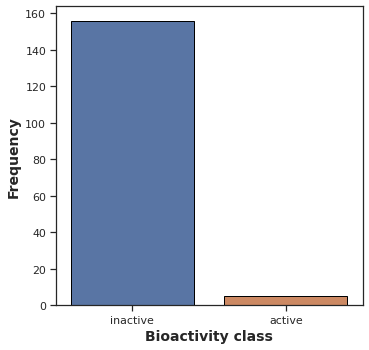

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

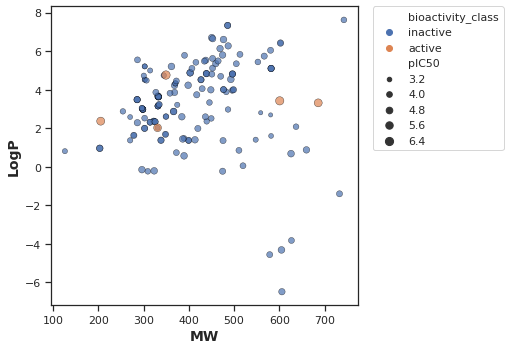

In [28]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='ALogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

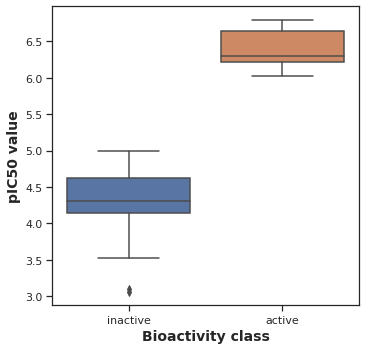

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [30]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [31]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.00007,0.05,Different distribution (reject H0)


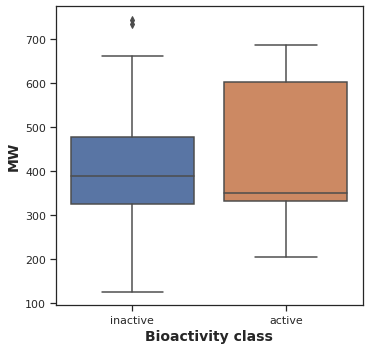

In [32]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [33]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,372.5,0.434204,0.05,Same distribution (fail to reject H0)


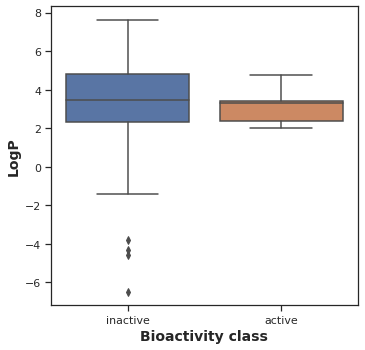

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'ALogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [39]:
mannwhitney('ALogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,ALogP,344.5,0.330487,0.05,Same distribution (fail to reject H0)


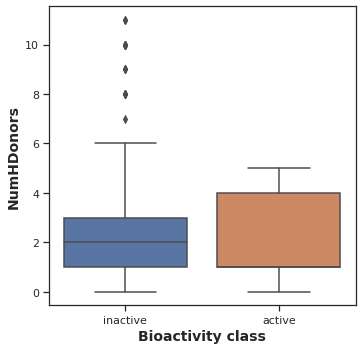

In [41]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [42]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,344.0,0.325201,0.05,Same distribution (fail to reject H0)


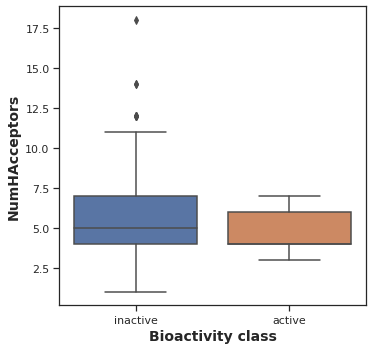

In [43]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [44]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,331.0,0.281512,0.05,Same distribution (fail to reject H0)


## Part 4: Building the Model 

In [38]:
# Importing relavant sklearn modules

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, accuracy_score

We have tried to run **three ML models**, on X and Y data, namely: <br>
1. Multiple Linear Regression<br>
2. Random Forest Model<br>
3. SVM Classification Model<br>
<br>The **R2 score/Accuracy** that we got for each model is displayed. 

In [ ]:
# We choose the final Data Descriptors dataframe we got from the above Part 3 as X,
# and the 'value' column of the database (given initially) as Y

X,Y=df4,df_final.value

In [ ]:
# Multiple linear Regression Model

r2_sum,i=0,0
for i in range(1000): # Repeating the model 1000 times and finding the average R2 Score
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
    
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    
    Y_pred = model.predict(X_test)
    r2_sum = r2_sum + r2_score(Y_test,Y_pred)
    
print("The R2 score (mean) that we are getting for this model is :",r2_sum/1000)

The R2 score (mean) that we are getting for this model is : 0.29493963178758204


In [ ]:
# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)
model = RandomForestRegressor(n_estimators=1000)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)

errors = np.abs(Y_pred-(Y_test).astype(float)) 
mape = 100 * (errors/((Y_test).astype(float)))
accuracy = 100-np.mean(mape) # mape = mean absolute percentage error

print("The accuracy of the model is: ",round(accuracy, 2), '%.')

The accuracy of the model is:  92.17 %.


In [ ]:
# Support Vector Machine-Classification Model

from sklearn import svm
def support_vector(x_data,y_data):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.50)
    model = svm.SVC(kernel ='linear')
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    return [confusion_matrix(y_test,y_pred),accuracy_score(y_test,y_pred)]

acc_score = support_vector(df_final[['ALogP','MW','NumHDonors','NumHAcceptors','PSA']],df_final.bioactivity_class)[1]
support_vector(df_final[['ALogP','MW','NumHDonors','NumHAcceptors','PSA']],df_final.bioactivity_class)

# In this model, we have taken only 'ALogP','MW','NumHDonors','NumHAcceptors' and 'PSA' and classified by 'bioactivity_class'

[array([[ 1,  3,  0],
        [ 2, 78,  0],
        [ 1, 22,  0]], dtype=int64), 0.7383177570093458]

In [ ]:
print("The accuracy of the model is: ",round(acc_score*100,2), '%.')

The accuracy of the model is:  73.83 %.


### Conclusion:
We tried to apply a few models (like above) on the data set we were able to prepare. The Random Forest Model seemed most promising of all the models. The observations and understandings have been detailed in the 'Project_Description.pdf' file, in the root directory.<br><br>
